# Lecture 09 Supplemental Notebook

Data 100, Spring 2023

[Acknowledgments Page](https://ds100.org/sp23/acks/)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(style='darkgrid', font_scale = 1.5,
              rc={'figure.figsize':(7,5)})

rng = np.random.default_rng()

## A fake election data set

Suppose that we are trying to run a poll to predict the mayoral election in Bearkeley City (an imaginary city that neighbors Berkeley).

First, let's grab a data set that has every single voter in Bearkeley (again, this is a fake dataset) and how they **actually** voted in the election.

For the purposes of this demo, assume:
* "high income" indicates a voter is above the median household income, which is $97,834 (actual Berkeley number).
* There are only two mayoral candidates: one Democrat and one Republican.
* Every registered voter votes in the election for the candidate under their registered party (Dem or Rep).


In [19]:
bearkeley = pd.read_csv("bearkeley.csv")

# create a 1/0 int that indicates democratic vote
bearkeley['vote.dem'] = (bearkeley['vote'] == 'Dem').astype(int)
bearkeley

,age,high_income,vote,vote.dem
0,35,False,Dem,1
1,42,True,Rep,0
2,55,False,Dem,1
3,77,True,Rep,0
4,31,False,Dem,1
...,...,...,...,...
1299995,62,True,Dem,1
1299996,78,True,Rep,0
1299997,68,False,Rep,0
1299998,82,True,Rep,0


What fraction of Bearkeley voters voted for the Democratic candidate?

In [34]:
actual_vote = np.mean(bearkeley["vote.dem"])
actual_vote

0.5302792307692308

This is the **actual outcome** of the election. Based on this result, the Democratic candidate would win. How did our sample of retirees do?

## Recreate the retiree sample

In [23]:
convenience_sample = bearkeley[bearkeley['age'] >= 65]
np.mean(convenience_sample["vote.dem"])

0.3744755089093924

Based on this result, we would have predicted that the Republican candidate would win! What happened?

1. Is the sample too small / noisy?

In [24]:
len(convenience_sample)

359396

In [25]:
len(convenience_sample)/len(bearkeley)

0.27645846153846154

Seems really large, so the error is definitely not solely chance error. There is some bias afoot.

## Check for bias

Let us aggregate all voters by age and visualize the fraction of Democratic voters, split by income.

In [28]:
votes_by_demo = bearkeley.groupby(["age","high_income"]).agg("mean").reset_index()
votes_by_demo

,age,high_income,vote.dem
0,18,False,0.819594
1,18,True,0.667001
2,19,False,0.812214
3,19,True,0.661252
4,20,False,0.805281
...,...,...,...
125,80,True,0.259731
126,81,False,0.394946
127,81,True,0.256759
128,82,False,0.398970


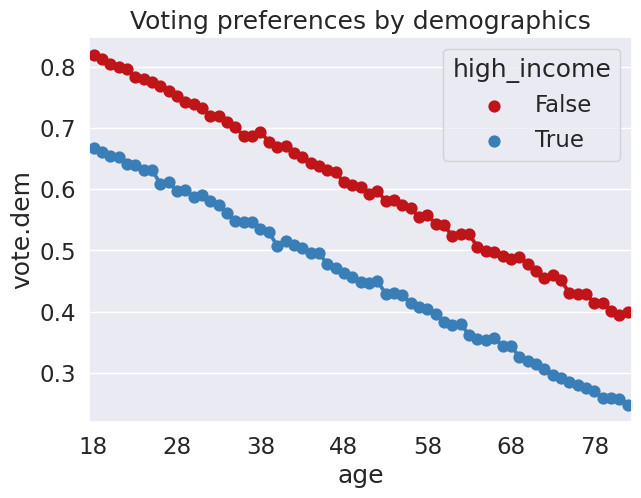

In [30]:
import matplotlib.ticker as ticker
fig = plt.figure();
red_blue = ["#bf1518", "#397eb7"]
with sns.color_palette(sns.color_palette(red_blue)):
    ax = sns.pointplot(data=votes_by_demo, x = "age", y = "vote.dem", hue = "high_income")

ax.set_title("Voting preferences by demographics")
fig.canvas.draw()
new_ticks = [i.get_text() for i in ax.get_xticklabels()];
plt.xticks(range(0, len(new_ticks), 10), new_ticks[::10]);


* We see that retirees (in our imaginary city) tend to vote less Democrat.
* We also see that voters below median income (`high_income=False`) tend to vote more democrat.

## Compare to a Simple Random Sample

What if we instead took a simple random sample (SRS) to conduct our pre-election poll?

Suppose we took an SRS of the same size as our retiree sample:

In [36]:
## By default, replace = False
n = len(convenience_sample)
random_sample = bearkeley.sample(n, replace = False)

np.mean(random_sample["vote.dem"])

0.5292101191999911

This is very close to the actual vote!

In [ ]:
actual_vote

0.5302792307692308

It turns out that we are pretty close, **much smaller sample size**, say, 800:

In [81]:
n = 800
random_sample = bearkeley.sample(n, replace = False)
np.mean(random_sample["vote.dem"])

0.54875

We'll learn how to choose this number when we (re)learn the Central Limit Theorem later in the semester.

## How to quantify chance error?

In our SRS of size 1000, what would be our chance error?

Let's simulate 1000 versions of taking the 500-size SRS from before:

In [86]:
poll_result = []
nrep = 1000   # number of simulations
n = 800       # size of our sample
for i in range(0,nrep):
    random_sample = bearkeley.sample(n, replace = False)
    poll_result.append(np.mean(random_sample["vote.dem"]))

<AxesSubplot:ylabel='Density'>

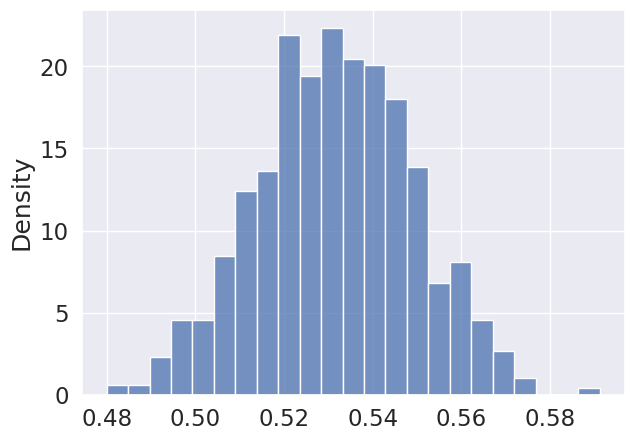

In [87]:
sns.histplot(poll_result, stat='density')

What fraction of these simulated samples would have predicted Democrat?

In [92]:
poll_result = pd.Series(poll_result)
np.sum(poll_result > 0.5)/1000

0.958

You can see the curve looks roughly Gaussian. Using KDE:

<AxesSubplot:ylabel='Count'>

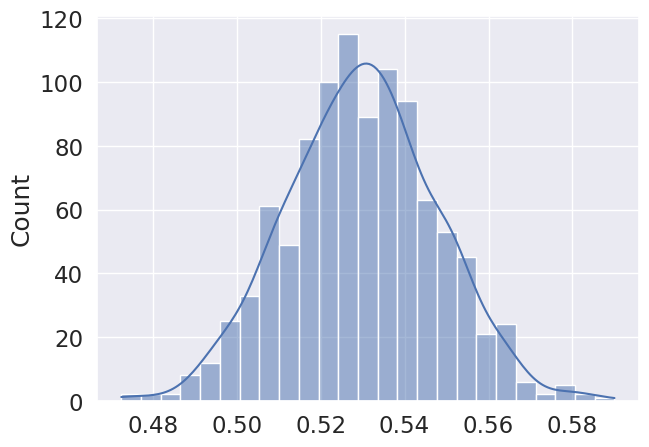

In [84]:
sns.histplot(poll_result, stat='density', kde=True)

---

## Simulating from a Multinomial Distribution

Sometimes instead of having individual reports in the population, we have **aggregate** statistics. For example, we could have only learned that 53\% of election voters voted Democrat. Even so, we can still simulate probability samples if we assume the population is large.

Specifically, we can use **multinomial** probabilities to simulate random samples **with replacement**.

### Marbles

Suppose we have a very large bag of marbles with the following statistics:
* 60\% blue
* 30\% green
* 10\% red

We then draw 100 marbles from this bag at random with replacement.

In [95]:
np.random.multinomial(100, [0.60, 0.30, 0.10])

array([58, 33,  9])

We can repeat this simulation multiple times, say 20:

In [96]:
np.random.multinomial(100, [0.60, 0.30, 0.10], size=20)

array([[62, 29,  9],
       [59, 32,  9],
       [60, 26, 14],
       [59, 29, 12],
       [64, 31,  5],
       [64, 27,  9],
       [57, 33, 10],
       [61, 33,  6],
       [52, 32, 16],
       [67, 22, 11],
       [62, 32,  6],
       [56, 30, 14],
       [66, 26,  8],
       [58, 31, 11],
       [56, 33, 11],
       [52, 33, 15],
       [60, 31,  9],
       [68, 19, 13],
       [64, 29,  7],
       [59, 30, 11]])